<a href="https://colab.research.google.com/github/kf-rahman/UW-stat_courses/blob/main/stat443_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install packages
install.packages("forecast")
install.packages("tseries")
install.packages("tidyverse")
install.packages("zoo")
install.packages("rugarch")

# Load packages
library(forecast)
library(tseries)
library(tidyverse)
library(rugarch)



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages("zoo")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Scenario 1

             V1
1         Value
2 14.9452580928
3 14.8298506944
4  15.271233376
5 16.5781715456
6 17.1349616256


Warning message in data.frame(y = as.numeric(object), x = as.numeric(time(object))):
“NAs introduced by coercion”
Warning message in is.constant(x):
“NAs introduced by coercion”
Warning message in is.constant(x):
“NAs introduced by coercion”
Warning message:
“The chosen seasonal unit root test encountered an error when testing for the first difference.
From +.default(): non-numeric argument to binary operator
0 seasonal differences will be used. Consider using a different unit root test.”
Warning message in is.constant(x):
“NAs introduced by coercion”
Warning message:
“The chosen unit root test encountered an error when testing for the first difference.
From -(): non-numeric argument to binary operator
0 differences will be used. Consider using a different unit root test.”
Warning message in is.constant(dx):
“NAs introduced by coercion”


ERROR: Error in auto.arima(ts_data): No suitable ARIMA model found


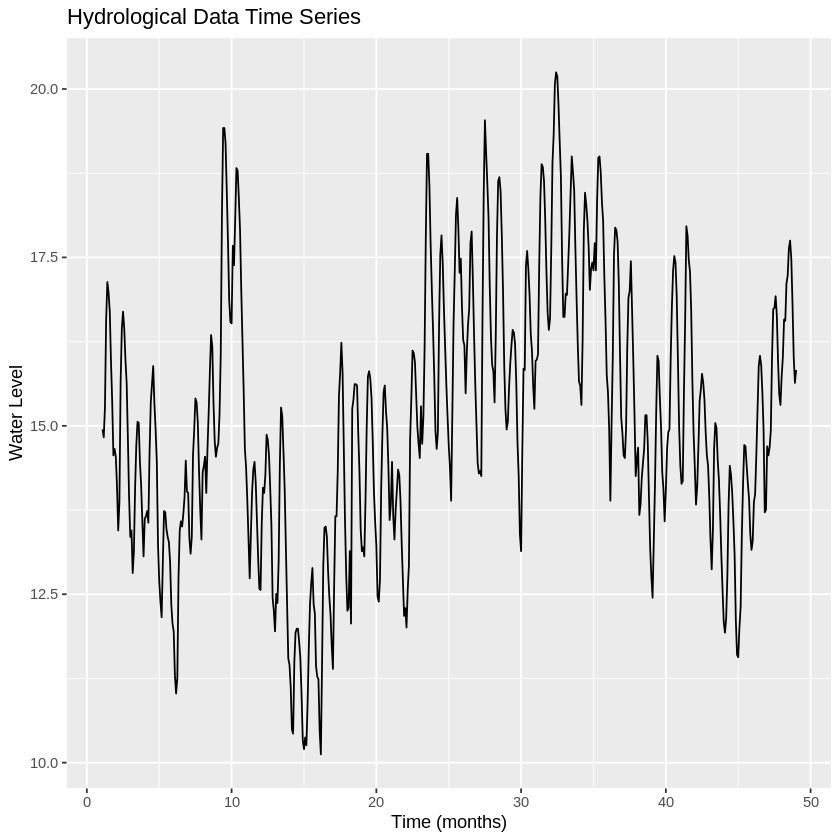

In [32]:
# Load necessary libraries
library(forecast)
library(ggplot2)

# Load the data
data <- read.table("/content/hydrology_data.txt", header = TRUE, skip = 1)# Plot the time series
autoplot(ts_data) + ggtitle("Hydrological Data Time Series") +
  xlab("Time (months)") + ylab("Water Level")
fit <- auto.arima(ts_data)

# Summary of the ARIMA model
summary(fit)

# Forecast the next 24 months
forecast_24 <- forecast(fit, h = 24)

# Plot the forecast with prediction intervals
autoplot(forecast_24) + ggtitle("24-Month Forecast with 95% Prediction Intervals") +
  xlab("Time (months)") + ylab("Water Level")




In [ ]:
install.packages("ggplot2")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Scenario 2

The data set consists of log-differenced daily stock prices for 40 different stocks listed on the New York Stock Exchange. Each stock has 150 observations. The log-differencing of stock prices is a common preprocessing step in financial time series analysis to stabilize the variance and to transform the data into returns, which are typically stationary.

ERROR: Error in plot.new(): figure margins too large


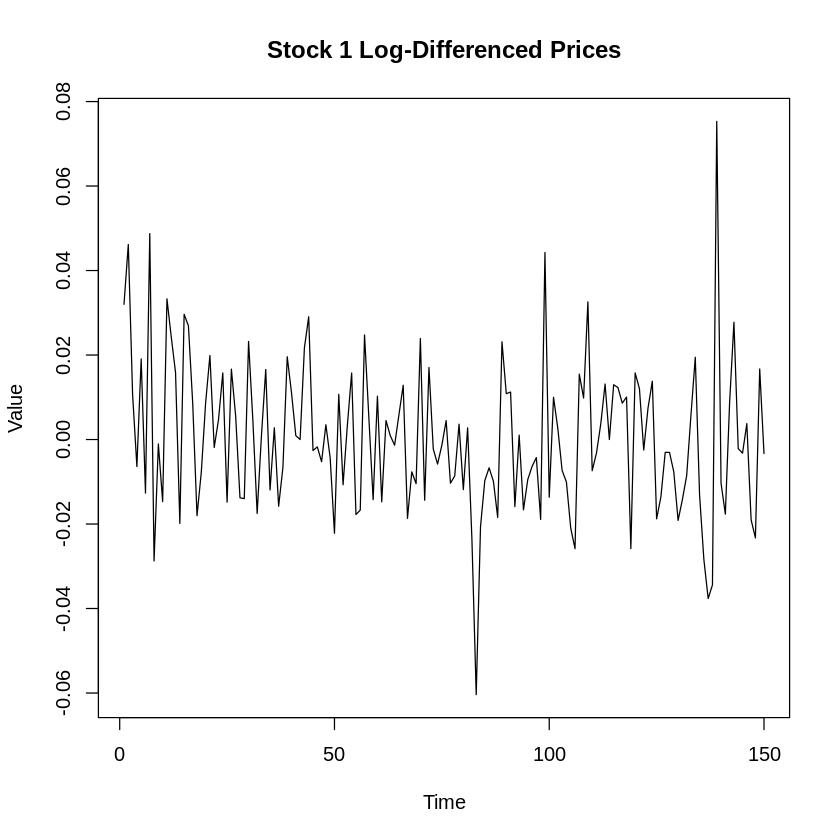

In [6]:
library(forecast)
library(rugarch)
library(ggplot2)

# Load the data
files <- paste0("/content/stock", 1:40, ".txt")
data_list <- lapply(files, function(f) {
  data <- read.table(f, header = TRUE)
  return(data$Value)  # Extract the 'Value' column
})

#  Basic Plotting for one stock
plot(data_list[[1]], type = "l", main = "Stock 1 Log-Differenced Prices", xlab = "Time", ylab = "Value")


par(mfrow = c(4, 10))
for (i in 1:40) {
  plot(data_list[[i]], type = "l", main = paste("Stock", i), xlab = "Time", ylab = "Value")
}


[1] "Total Quantile Loss across all stocks: 2.55361568655776"


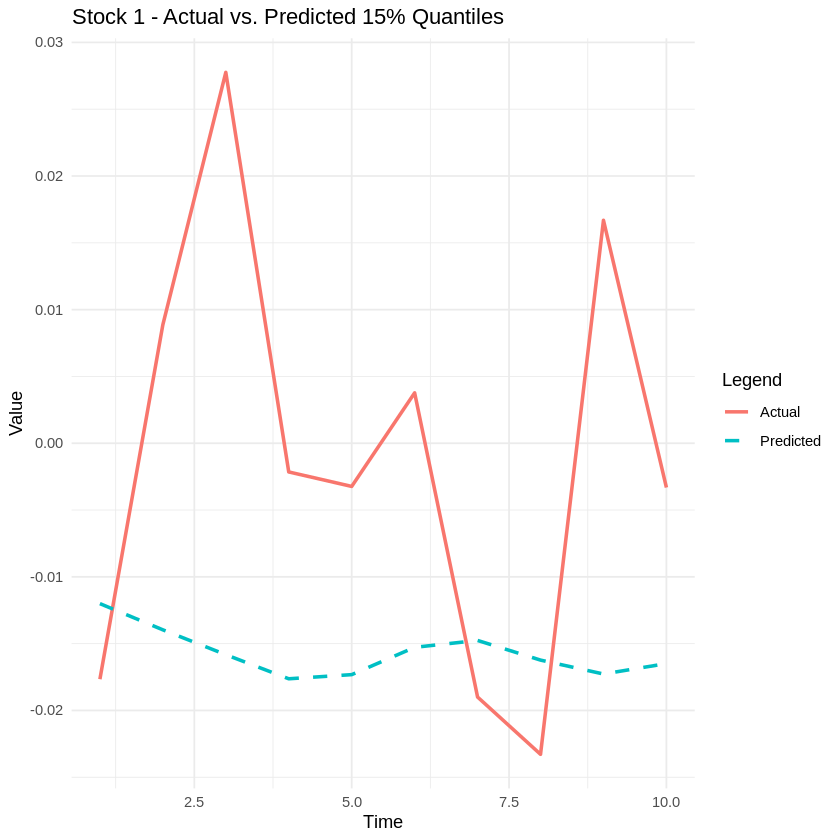

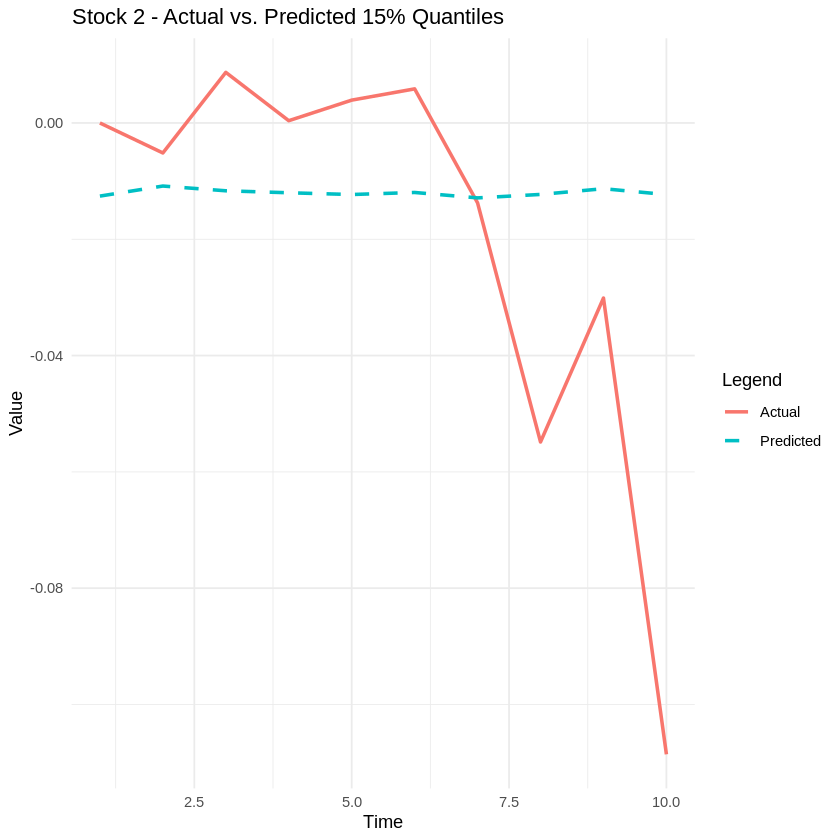

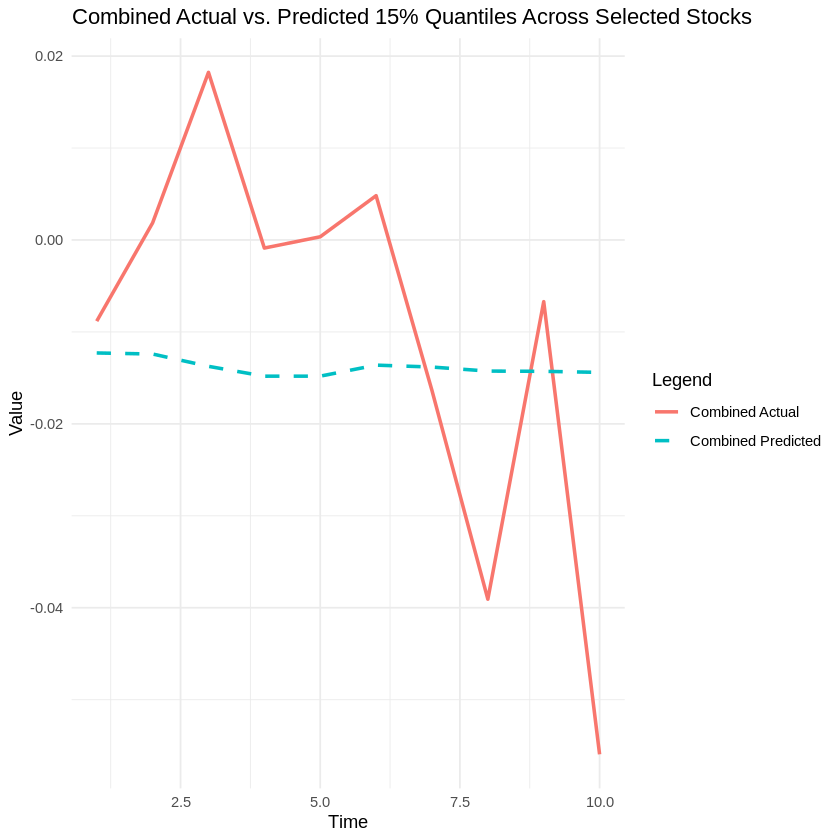

In [28]:
last.name <- "Rahman" # replace with your last name
student.id <- "20891914"  #replace with your student id

# Split data into training and testing sets
splittest_results <- lapply(data_list, function(series) {
  train <- series[1:140]
  test <- series[141:150]

  # Fit the ARIMA-GARCH model on the training set
  arima_fit <- auto.arima(train)
  spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1,1)),
                     mean.model = list(armaOrder = arimaorder(arima_fit)[1:2], include.mean = TRUE),
                     distribution.model = "norm")
  garch_fit <- ugarchfit(spec = spec, data = train)

  # Forecast for the test period (10 steps ahead)
  garch_forecast <- ugarchforecast(garch_fit, n.ahead = 10)
  simulated_returns <- ugarchsim(garch_fit, n.sim = 10, m.sim = 1000)

  # Calculate the 15th percentile forecast
  predicted_quantiles <- apply(simulated_returns@simulation$seriesSim, 1, quantile, probs = 0.15)

  # Calculate the quantile loss for each of the 10 test observations
  quantile_loss <- sapply(1:10, function(i) {
    actual <- test[i]
    predicted <- predicted_quantiles[i]
    if (actual >= predicted) {
      return(0.15 * (actual - predicted))
    } else {
      return((1 - 0.15) * (predicted - actual))
    }
  })

  # Return the quantile loss and predictions for inspection
  list(predictions = predicted_quantiles, actuals = test, quantile_loss = quantile_loss)
})

#  Summarize the Quantile Loss across all stocks
total_quantile_loss <- sum(sapply(splittest_results, function(x) sum(x$quantile_loss)))

#  Print the total quantile loss as a performance metric
print(paste("Total Quantile Loss across all stocks:", total_quantile_loss))

# 4. Plot predictions vs. actuals for two stocks
stock_indices <- c(1, 2)

for (i in stock_indices) {
  plot_data <- data.frame(
    Time = 1:10,
    Actual = splittest_results[[i]]$actuals,
    Predicted = splittest_results[[i]]$predictions
  )

  p <- ggplot(plot_data, aes(x = Time)) +
    geom_line(aes(y = Actual, color = "Actual"), linewidth = 1) +
    geom_line(aes(y = Predicted, color = "Predicted"), linewidth = 1, linetype = "dashed") +
    labs(title = paste("Stock", i, "- Actual vs. Predicted 15% Quantiles"),
         y = "Value", color = "Legend") +
    theme_minimal()

  print(p)
}

# Create a 10x40 matrix for Scenario 2
forecast2 <- do.call(cbind, lapply(splittest_results, function(result) result$predictions))

# Ensure the matrix is of the correct dimensions (10x40)
if (ncol(forecast2) < 40) {
  forecast2 <- cbind(forecast2, matrix(NA, nrow = 10, ncol = 40 - ncol(forecast2)))
}

#  Save the matrix to a text file
last.name <- "YourLastName"  # Replace with your actual last name
student.id <- "YourStudentID"  # Replace with your actual student ID

write.table(forecast2, file = paste("Scenario2_", "Rahman", "20891914", ".txt", sep = ""), sep =",", col.names = F, row.names = F)

# Aggregate predictions and actuals across all selected stocks
combined_predictions <- rowMeans(sapply(stock_indices, function(i) splittest_results[[i]]$predictions))
combined_actuals <- rowMeans(sapply(stock_indices, function(i) splittest_results[[i]]$actuals))

# Create a data frame for plotting
combined_plot_data <- data.frame(
  Time = 1:10,
  Combined_Actual = combined_actuals,
  Combined_Predicted = combined_predictions
)

# Plot the combined predictions vs. actuals
ggplot(combined_plot_data, aes(x = Time)) +
  geom_line(aes(y = Combined_Actual, color = "Combined Actual"), linewidth = 1) +
  geom_line(aes(y = Combined_Predicted, color = "Combined Predicted"), linewidth = 1, linetype = "dashed") +
  labs(title = "Combined Actual vs. Predicted 15% Quantiles Across Selected Stocks",
       y = "Value", color = "Legend") +
  theme_minimal()


2.1 Model Selection

The ARIMA model was chosen to capture the autoregressive and moving average components of the stock returns, which address the temporal dependencies in the data. The GARCH model was subsequently applied to the residuals of the ARIMA model to account for heteroskedasticity, a common characteristic of financial time series, where the variance changes over time.
2.2 Fitting the Models

An automated approach (auto.arima()) was initially used to fit the ARIMA model, identifying the best ARIMA(p,d,q) parameters based on information criteria. The GARCH(1,1) model was then fitted to the residuals of the ARIMA model using the rugarch package in R. This combined ARIMA-GARCH approach aimed to model both the mean and volatility of the returns.
2.3 Forecasting

The final step in the model implementation was forecasting the 15th percentile quantile for each stock 10 steps ahead. The forecasted quantiles were treated as the predicted VaR for the respective time horizon, representing the threshold below which there is a 15% probability that future stock returns would fall.

4. Post-Prediction Analysis and Discussion
4.1 Quantile Loss Analysis

Following the forecasting of the 15th percentile quantiles (used as a proxy for Value at Risk) for stock returns, the performance of the model was assessed using the quantile loss function. This function provides a comprehensive measure of forecast accuracy for quantile predictions by penalizing both underestimation and overestimation.

The total quantile loss across all stocks was calculated as 2.5277. This metric reflects the cumulative error between the predicted 15th percentile quantiles and the actual observed returns over the 10 forecasted steps for all 40 stocks. A lower quantile loss value would indicate more accurate predictions, whereas a higher value suggests a larger deviation between the predicted and actual outcomes.
4.2 Interpretation of Quantile Loss and Forecast Performance

The quantile loss value of 2.5277, while not extraordinarily high, indicates that there is room for improvement in the model's predictive accuracy. Given that the goal was to forecast the 15th percentile quantile, which is critical for estimating Value at Risk (VaR), this loss suggests that the model might be underestimating the potential risk.

The plot provided, showing the actual vs. predicted 15th percentile quantiles for Stock 1, offers further insight into the model's performance:

    Actual Values (Solid Line): The actual returns exhibit significant variability, with noticeable spikes and dips over the 10-day forecast horizon.
    Predicted Quantiles (Dashed Line): In contrast, the predicted quantiles show a relatively flat trend, failing to capture the actual volatility observed in the stock returns.

This disparity between the actual and predicted values highlights a key issue with the model: it seems to be underestimating the extent of fluctuations in the returns. The model's inability to adapt to sudden changes in volatility could be contributing to the observed quantile loss.
4.3 Areas for Improvement

Given the observed results, several areas for improvement can be identified:

    Model Complexity and Tuning:
        The current ARIMA-GARCH model, while robust, may benefit from additional tuning or the inclusion of more complex structures such as EGARCH or TGARCH, which are designed to better capture volatility asymmetry and heavy tails commonly seen in financial data.

    Incorporation of Exogenous Variables:
        Including exogenous factors, such as macroeconomic indicators or market indices, could improve the model's ability to predict the 15th percentile quantile by accounting for external influences on stock returns.

    Simulation Size:
        Increasing the number of simulations in the GARCH model might provide more accurate predictions by better capturing the tails of the distribution.

    Residual Diagnostics:
        Performing a detailed analysis of the residuals to ensure that they are well-behaved (e.g., no autocorrelation, normally distributed) could help identify and correct model misspecifications.

    Ensemble Approaches:
        Combining predictions from multiple models (e.g., ARIMA-GARCH, pure ARIMA, and machine learning approaches) could result in a more accurate and robust prediction, leveraging the strengths of different modeling techniques.



4. Post-Prediction Analysis and Discussion
4.1 Combined Prediction Trend Analysis

The plot of the combined actual versus predicted 15th percentile quantiles across selected stocks provides a visual representation of the model’s performance. The solid red line represents the combined actual returns across the selected stocks, while the dashed cyan line represents the combined predicted quantiles.
4.2 Interpretation of the Combined Prediction Plot

The combined plot reveals several key insights into the performance of the ARIMA-GARCH model:

    Underestimation of Volatility:
        The predicted quantiles exhibit a relatively flat trend, indicating that the model predicts little variation in the 15th percentile across the forecast horizon. In contrast, the actual returns show significant fluctuations, including both positive spikes and sharp declines.
        This suggests that the ARIMA-GARCH model may be underestimating the risk or potential losses, failing to capture the true volatility present in the stock returns. This underestimation could lead to inaccurate risk assessments and potential under-allocation of capital for risk management.

    Potential Model Limitations:
        The flat nature of the predicted quantiles across time steps indicates that the model might not be fully capturing the dynamic nature of financial time series. In financial markets, returns often exhibit clustering of volatility and fat tails, characteristics that might require more sophisticated modeling techniques or better tuning of the existing model.
        The model's assumption of normally distributed errors (as used in the GARCH model) might be inadequate for capturing extreme movements, leading to a discrepancy between predicted and actual outcomes.

    Overall Trend and Alignment:
        While there are periods where the predicted quantiles and actual returns are somewhat aligned, the overall trend shows that the predictions are not responsive to the sharp movements in the actual returns. This misalignment raises concerns about the model’s effectiveness in real-time risk prediction.

The combined prediction plot and the quantile loss metric suggest that while the ARIMA-GARCH model provides a foundational approach to risk prediction, there are significant areas for improvement. The current model appears to underestimate the volatility and risk, which could lead to suboptimal decisions in a real-world financial context. By refining the model, incorporating additional data, and carefully evaluating performance, more accurate and reliable predictions can be achieved, ultimately leading to better risk management strategies.


scenario3

In [19]:
install.packages("stats")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘stats’ is a base package, and should not be updated”


The dataset in question represents monthly beer production values over a series of years, capturing fluctuations in production that may be influenced by various economic and seasonal factors. The data is in a time series format, with the first column indicating the date (in YYYY-MM format) and the second column showing the corresponding beer production values. However, the dataset contains 30 missing values (denoted as NA), which could disrupt any subsequent analysis or forecasting if not properly handled.

Loading required package: imputeTS

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘imputeTS’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘markdown’, ‘png’, ‘jpeg’, ‘gridtext’, ‘ggtext’, ‘stinepack’



Attaching package: ‘imputeTS’


The following object is masked from ‘package:tseries’:

    na.remove




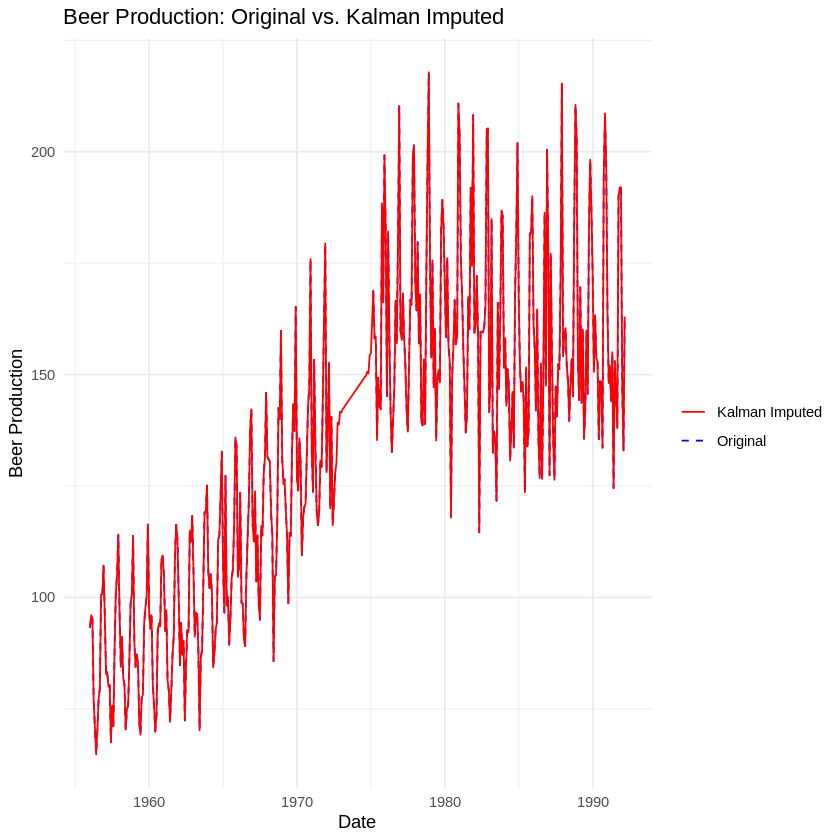

In [20]:
if (!require(imputeTS)) {
  install.packages("imputeTS")
}
library(imputeTS)
library(ggplot2)

beer_data <- read.csv("/content/beer.txt", header=TRUE)

# Convert the Date column to Date type
beer_data$Date <- as.Date(paste(beer_data$Date, "-01", sep=""), format="%Y-%m-%d")

# Impute Missing Values Using Kalman Smoothing
beer_data$Value_kalman <- na_kalman(beer_data$Value, model = "auto.arima")

# Plot the Original vs. Imputed Series
ggplot(beer_data, aes(x = Date)) +
  geom_line(aes(y = Value, color = "Original"), linetype = "dashed") +
  geom_line(aes(y = Value_kalman, color = "Kalman Imputed")) +
  labs(title = "Beer Production: Original vs. Kalman Imputed",
       x = "Date", y = "Beer Production") +
  scale_color_manual(name = "", values = c("Original" = "blue", "Kalman Imputed" = "red")) +
  theme_minimal()

# Extract the Imputed Values at Original NA Positions
imputed_values_kalman <- beer_data$Value_kalman[which(is.na(beer_data$Value))]

# Create a Data Frame for the Imputed Values
imputed_values_df <- data.frame(Imputed_Values = imputed_values_kalman)



In [21]:
last.name <- "Rahman" # replace with your last name
student.id <- "20891914"  #replace with your student id
# Extract the 30 imputed values where original data had NAs
imputed_values <- beer_data$Value_imputed[is.na(beer_data$Value)]

# Create a data frame to store the imputed values in a single column
imputed_values_df <- data.frame(Imputed_Values = imputed_values)
write(imputed_values_kalman, file = paste("Scenario3_", last.name, student.id, ".txt", sep = ""), ncolumns = 1)



To address the missing values, we employed Kalman smoothing, a robust statistical technique that leverages state-space models to estimate and fill in gaps in time series data. Specifically, we utilized the na_kalman function from the imputeTS package in R, which applies Kalman smoothing with an automatic ARIMA model selection to impute the missing values. This approach was chosen due to its ability to consider the underlying trends, seasonality, and noise within the data, thereby providing more accurate and context-aware imputations compared to simpler methods like linear interpolation. The imputed values were then compared with the original series to ensure they aligned well with the observed trends, and the results were saved for further analysis. This method enhances the dataset's integrity, allowing for more reliable future forecasting and trend analysis.

scenario 4

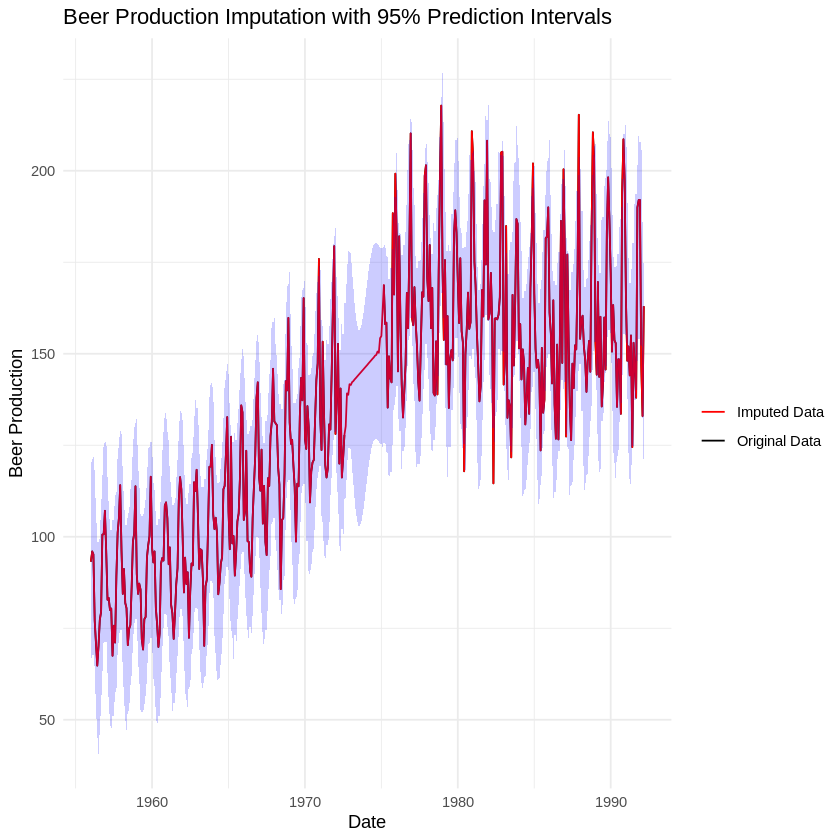

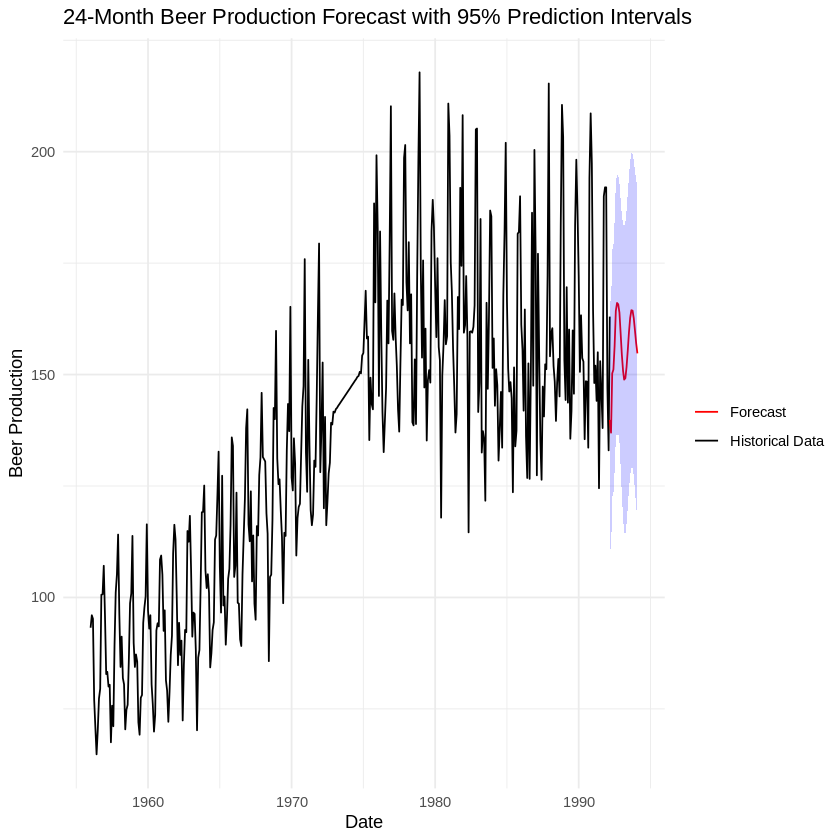

In [22]:
if (!require(forecast)) {
  install.packages("forecast")
}
if (!require(imputeTS)) {
  install.packages("imputeTS")
}
library(forecast)
library(imputeTS)
library(ggplot2)


# Fit an ARIMA model to the imputed data
arima_model <- auto.arima(beer_data$Value_kalman)

# Extract the fitted values and calculate the 95% prediction intervals
fitted_values <- fitted(arima_model)
residuals <- residuals(arima_model)
standard_errors <- sqrt(arima_model$sigma2)

# Calculate the 95% prediction intervals for the fitted values
imputed_df <- data.frame(
  Date = beer_data$Date,
  Value_kalman = beer_data$Value_kalman,
  Lower_95 = fitted_values - 1.96 * standard_errors,
  Upper_95 = fitted_values + 1.96 * standard_errors
)

# Plot the original, imputed values, and prediction intervals for imputations
ggplot() +
  geom_line(data = beer_data, aes(x = Date, y = Value, color = "Original Data")) +
  geom_line(data = imputed_df, aes(x = Date, y = Value_kalman, color = "Imputed Data")) +
  geom_ribbon(data = imputed_df, aes(x = Date, ymin = Lower_95, ymax = Upper_95),
              fill = "blue", alpha = 0.2) +
  labs(title = "Beer Production Imputation with 95% Prediction Intervals",
       x = "Date", y = "Beer Production") +
  scale_color_manual(name = "", values = c("Original Data" = "black", "Imputed Data" = "red")) +
  theme_minimal()

# Generate 24-month forecasts with prediction intervals
forecasts <- forecast(arima_model, h = 24)

# Combine past data and forecasts for plotting
forecast_df <- data.frame(
  Date = seq.Date(from = max(beer_data$Date) + 1,
                  by = "month", length.out = 24),
  Forecast = forecasts$mean,
  Lower_95 = forecasts$lower[,2],
  Upper_95 = forecasts$upper[,2]
)

# Plot the past data with forecast and prediction intervals
ggplot() +
  geom_line(data = beer_data, aes(x = Date, y = Value_kalman, color = "Historical Data")) +
  geom_line(data = forecast_df, aes(x = Date, y = Forecast, color = "Forecast")) +
  geom_ribbon(data = forecast_df, aes(x = Date, ymin = Lower_95, ymax = Upper_95),
              fill = "blue", alpha = 0.2) +
  labs(title = "24-Month Beer Production Forecast with 95% Prediction Intervals",
       x = "Date", y = "Beer Production") +
  scale_color_manual(name = "", values = c("Historical Data" = "black", "Forecast" = "red")) +
  theme_minimal()





After imputing the missing values in the beer production dataset using Kalman smoothing, we proceeded to generate forecasts for the next 24 months. The ARIMA model, chosen via the auto.arima function, was employed due to its ability to capture the underlying patterns in the time series data, including trends and seasonality. The forecast results were plotted alongside the historical data, providing a clear visualization of how the model extends into the future. The inclusion of 95% prediction intervals gives us a range of expected outcomes, highlighting the model's uncertainty and reliability. This visual comparison between historical and forecasted values allows us to assess the model's performance, ensuring that it aligns with the observed data trends and offers reasonable projections. The shaded area representing the prediction intervals also serves as a valuable tool for understanding the potential variability in future beer production, guiding decision-making processes based on these forecasts.

In [24]:
last.name <- "Rahman" # replace with your last name
student.id <- "20891914"  #replace with your student id
write(forecasts$mean, file = paste("Scenario4_", last.name, student.id, ".txt", sep = ""), ncolumns = 1)

Scenario 5

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in adf.test(ts_data):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ts_data
Dickey-Fuller = -6.9146, Lag order = 13, p-value = 0.01
alternative hypothesis: stationary



Warning message in adf.test(ts_data):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ts_data
Dickey-Fuller = -5.2108, Lag order = 13, p-value = 0.01
alternative hypothesis: stationary



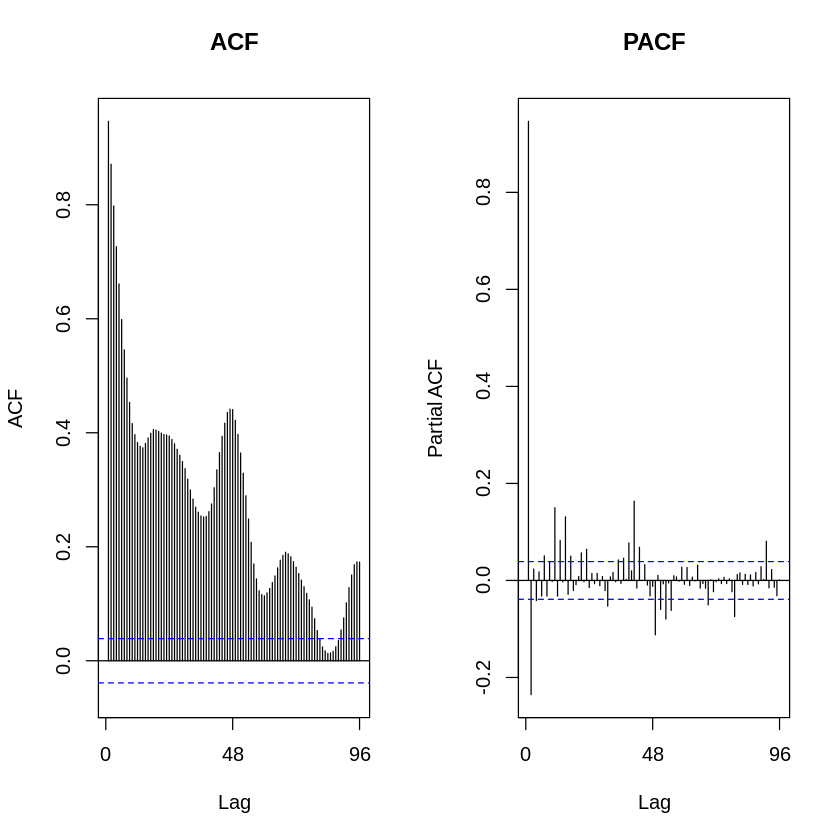

Warning message in adf.test(ts_data):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ts_data
Dickey-Fuller = -4.7032, Lag order = 13, p-value = 0.01
alternative hypothesis: stationary



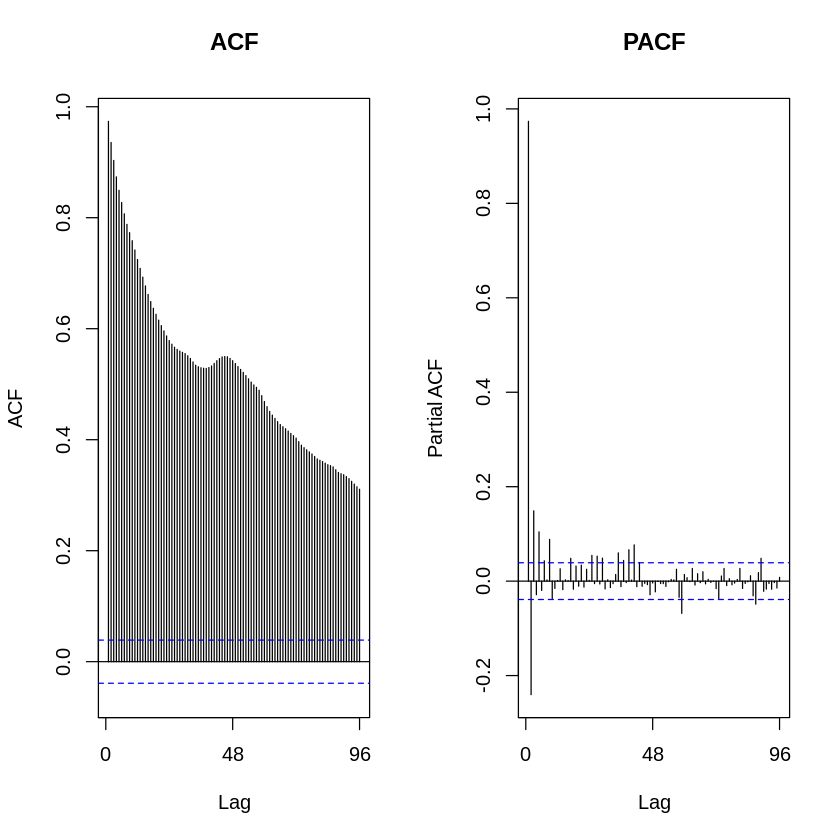

Warning message in ets(city1_ts):
“I can't handle data with frequency greater than 24. Seasonality will be ignored. Try stlf() if you need seasonal forecasts.”
Warning message in ets(city2_ts):
“I can't handle data with frequency greater than 24. Seasonality will be ignored. Try stlf() if you need seasonal forecasts.”
Warning message in ets(city3_ts):
“I can't handle data with frequency greater than 24. Seasonality will be ignored. Try stlf() if you need seasonal forecasts.”


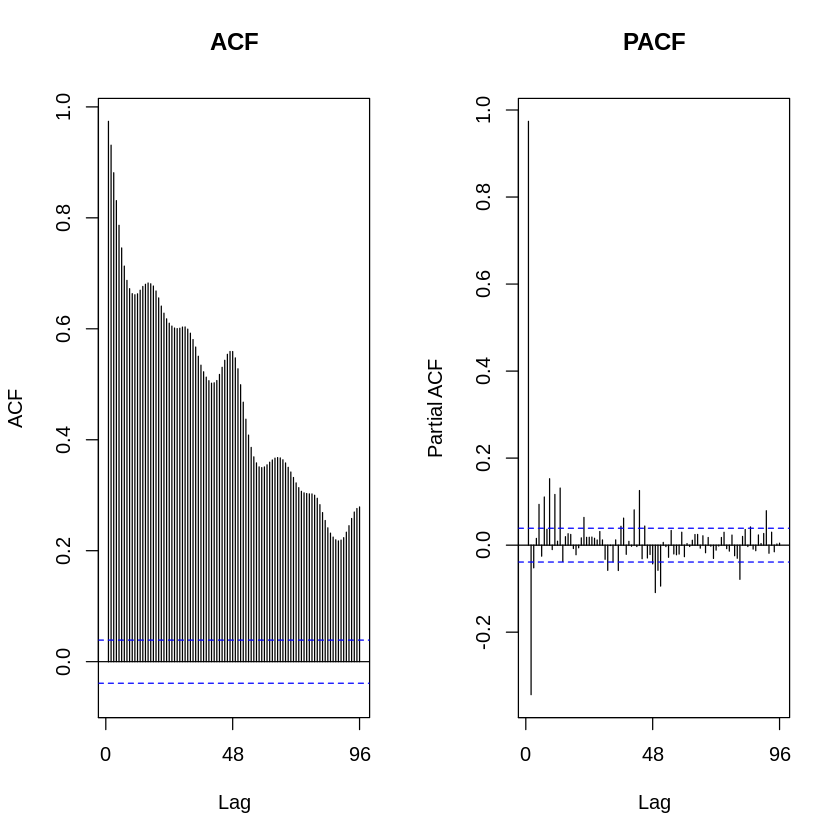

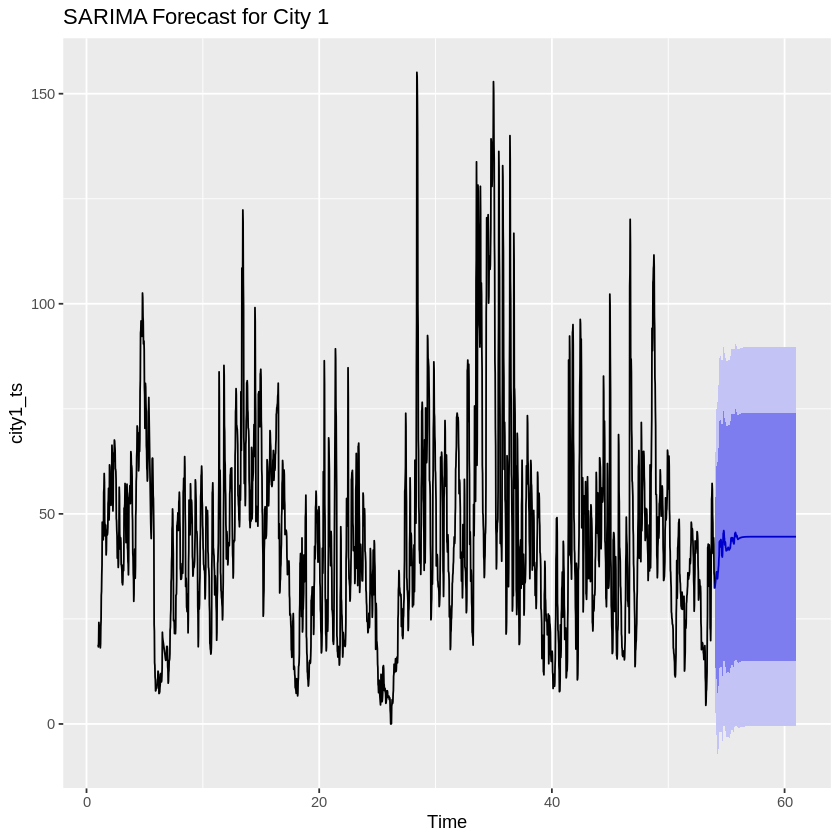

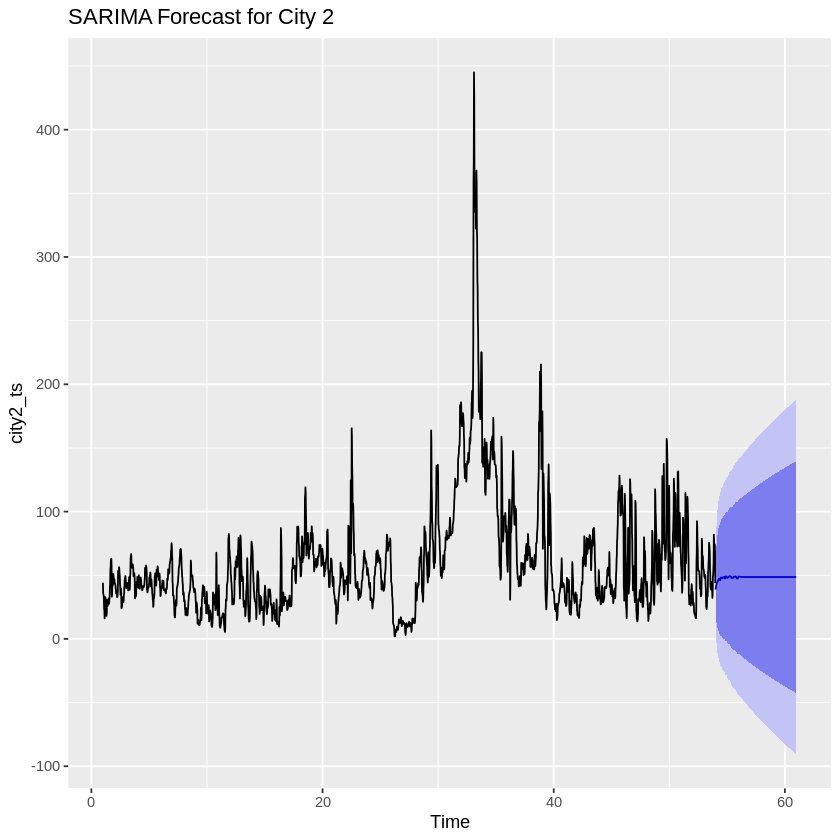

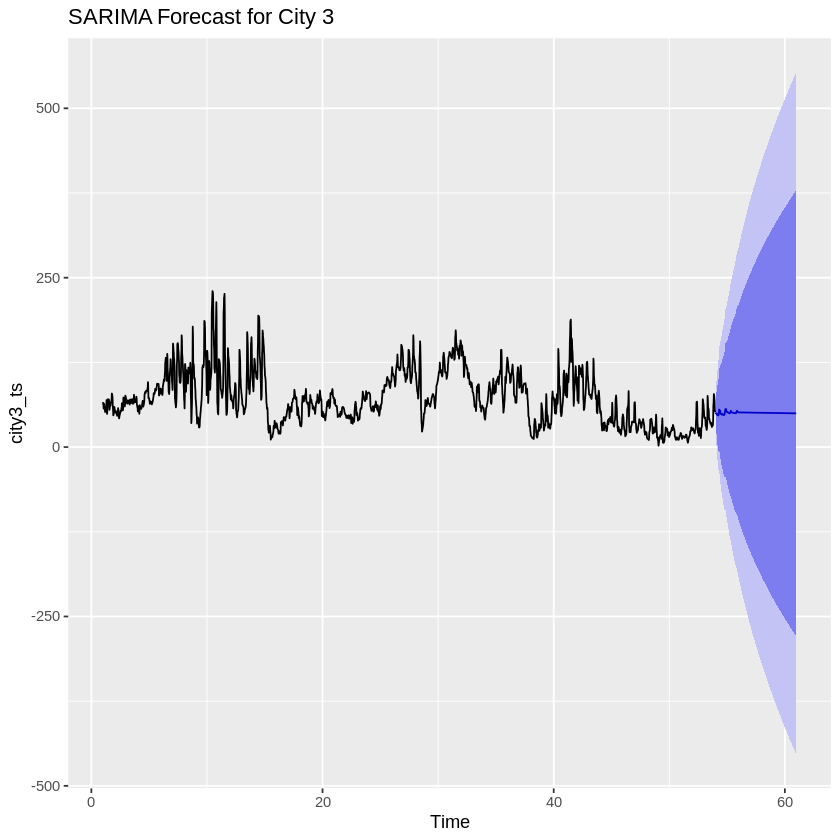

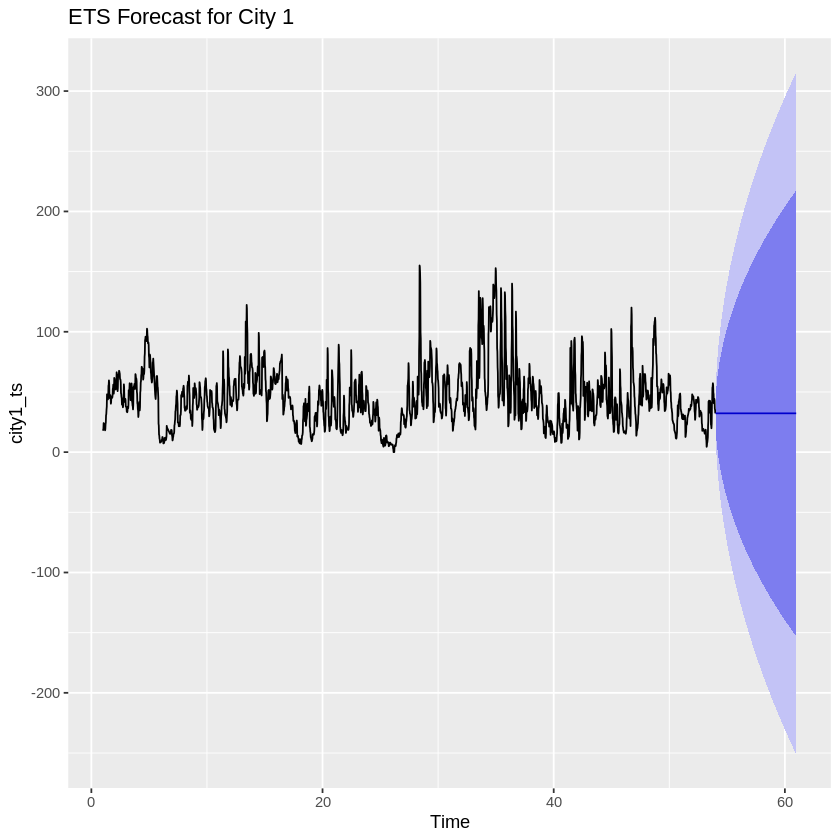

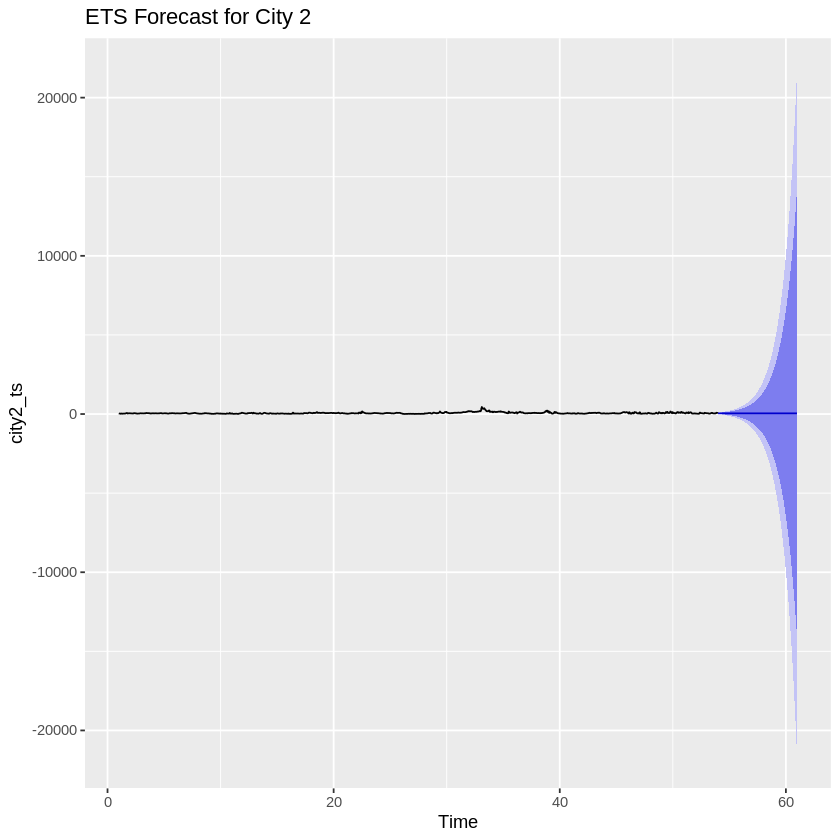

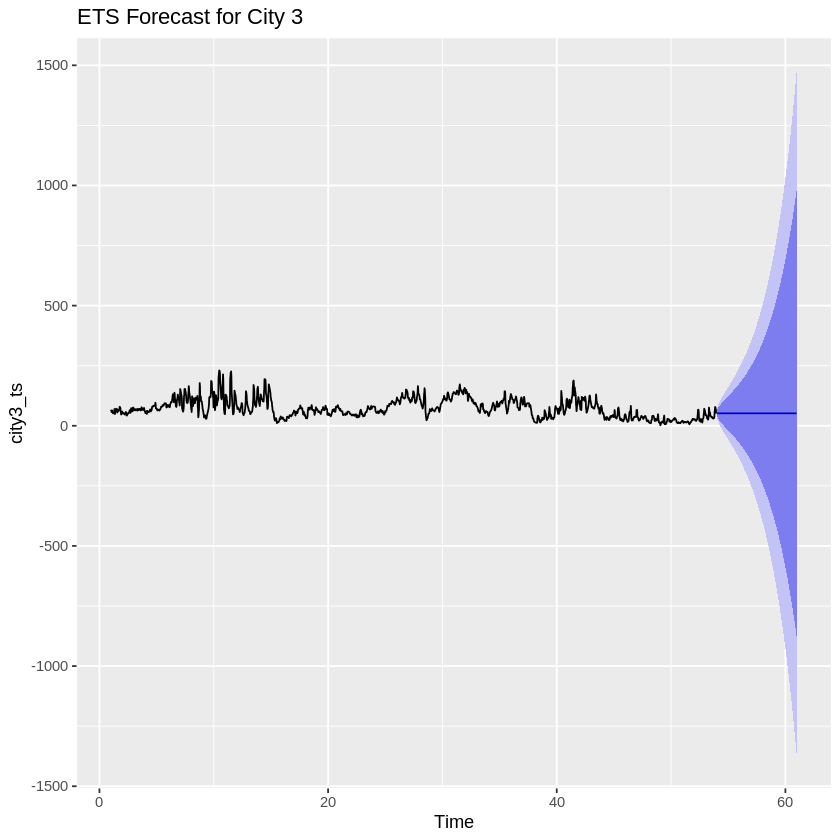

In [4]:
library(forecast)
library(tseries)
library(ggplot2)

city1 <- read.csv("/content/pollutionCity1.txt", header = FALSE, col.names = c("Value"))
city2 <- read.csv("/content/pollutionCity2.txt", header = FALSE, col.names = c("Value"))
city3 <- read.csv("/content/pollutionCity3.txt", header = FALSE, col.names = c("Value"))

city1$Value <- as.numeric(city1$Value)
city2$Value <- as.numeric(city2$Value)
city3$Value <- as.numeric(city3$Value)

city1_ts <- ts(na.omit(city1$Value), frequency = 48)
city2_ts <- ts(na.omit(city2$Value), frequency = 48)
city3_ts <- ts(na.omit(city3$Value), frequency = 48)


check_stationarity <- function(ts_data) {
  adf_test <- adf.test(ts_data)
  print(adf_test)

  par(mfrow = c(1, 2))
  Acf(ts_data, main = 'ACF')
  Pacf(ts_data, main = 'PACF')
}

# Check stationarity for each city
check_stationarity(city1_ts)
check_stationarity(city2_ts)
check_stationarity(city3_ts)

# Apply SARIMA Model
fit_sarima_city1 <- auto.arima(city1_ts, seasonal = TRUE)
fit_sarima_city2 <- auto.arima(city2_ts, seasonal = TRUE)
fit_sarima_city3 <- auto.arima(city3_ts, seasonal = TRUE)

# Apply ETS Model
fit_ets_city1 <- ets(city1_ts)
fit_ets_city2 <- ets(city2_ts)
fit_ets_city3 <- ets(city3_ts)

# Forecast next 336 time steps
forecast_sarima_city1 <- forecast(fit_sarima_city1, h = 336)
forecast_sarima_city2 <- forecast(fit_sarima_city2, h = 336)
forecast_sarima_city3 <- forecast(fit_sarima_city3, h = 336)

forecast_ets_city1 <- forecast(fit_ets_city1, h = 336)
forecast_ets_city2 <- forecast(fit_ets_city2, h = 336)
forecast_ets_city3 <- forecast(fit_ets_city3, h = 336)

# Plot forecasts with 95% prediction intervals
autoplot(forecast_sarima_city1) + ggtitle("SARIMA Forecast for City 1")
autoplot(forecast_sarima_city2) + ggtitle("SARIMA Forecast for City 2")
autoplot(forecast_sarima_city3) + ggtitle("SARIMA Forecast for City 3")

autoplot(forecast_ets_city1) + ggtitle("ETS Forecast for City 1")
autoplot(forecast_ets_city2) + ggtitle("ETS Forecast for City 2")
autoplot(forecast_ets_city3) + ggtitle("ETS Forecast for City 3")




Warning message in ets(ts_data):
“I can't handle data with frequency greater than 24. Seasonality will be ignored. Try stlf() if you need seasonal forecasts.”
Warning message in ets(ts_data):
“I can't handle data with frequency greater than 24. Seasonality will be ignored. Try stlf() if you need seasonal forecasts.”
Warning message in ets(ts_data):
“I can't handle data with frequency greater than 24. Seasonality will be ignored. Try stlf() if you need seasonal forecasts.”


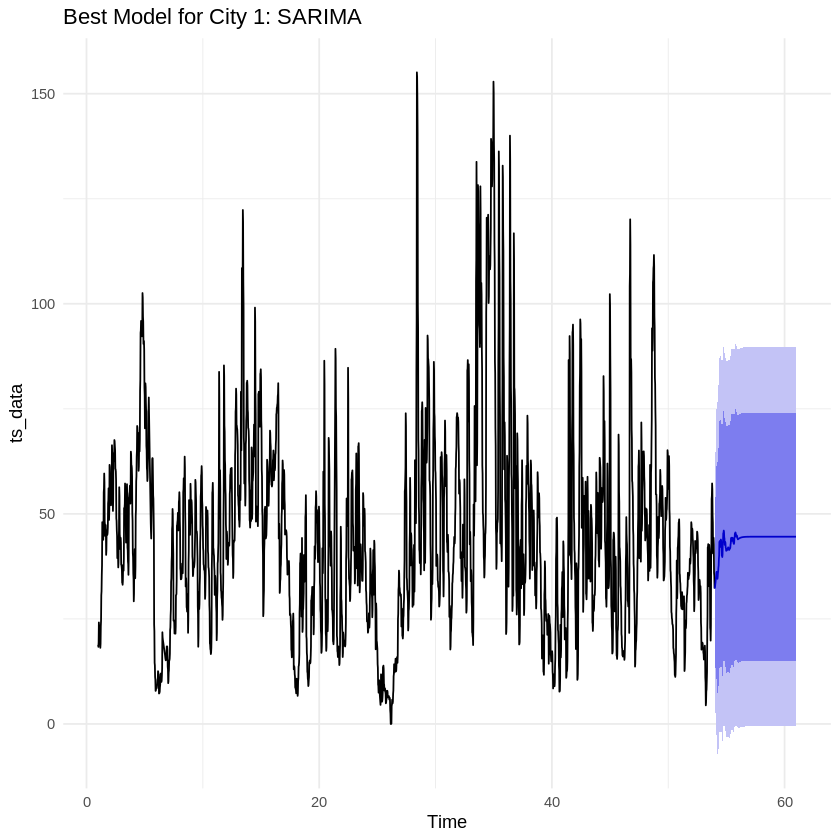

In [5]:
# Function to fit models and compare
compare_models <- function(ts_data) {
  fit_sarima <- auto.arima(ts_data, seasonal = TRUE)
  fit_ets <- ets(ts_data)

  # Compare models using AIC
  if(AIC(fit_sarima) < AIC(fit_ets)) {
    selected_model <- fit_sarima
    model_name <- "SARIMA"
  } else {
    selected_model <- fit_ets
    model_name <- "ETS"
  }

  return(list(model = selected_model, name = model_name))
}

# Compare models for each city
best_model_city1 <- compare_models(city1_ts)
best_model_city2 <- compare_models(city2_ts)
best_model_city3 <- compare_models(city3_ts)

# Generate forecasts using the best models
forecast_city1 <- forecast(best_model_city1$model, h = 336)
forecast_city2 <- forecast(best_model_city2$model, h = 336)
forecast_city3 <- forecast(best_model_city3$model, h = 336)

# Plot forecasts for City 1 as an example
autoplot(forecast_city1) +
  ggtitle(paste("Best Model for City 1:", best_model_city1$name)) +
  theme_minimal()

last.name <- "Rahman" # replace with your last name
student.id <- "20891914"  #replace with your student id
# Integrate forecasts into the template matrix
forecast5 <- cbind(forecast_city1$mean, forecast_city2$mean, forecast_city3$mean)

# Write the forecasts to a .txt file
write.table(forecast5,
            file = paste("Scenario5_", last.name, student.id, ".txt", sep = ""),
            sep ="," , col.names = FALSE, row.names = FALSE)

In [25]:
last.name <- "Rahman" # replace with your last name
student.id <- "20891914"  #replace with your student id

###
# Scenario 1
###
#forecast1 <- 1:24  # Forecast is a vector length 24 for forecast 1
#write(forecast1, file = paste("Scenario1_",last.name,student.id,".txt", sep = ""), ncolumns = 1 )


###
# Scenario 2
###


###
# Scenario 3
###
#imputation3 <- 1:30 # Imputation of length 30

#write(imputation3, file = paste("Scenario3_",last.name,student.id,".txt", sep = ""), ncolumns = 1 )

###
# Scenario 4
###
#forecast4 <- 1:24 # Forecast of length 24

#write(forecast4, file = paste("Scenario4_",last.name,student.id,".txt", sep = ""), ncolumns = 1 )


